In [1]:
import os
import pickle

import cv2
import numpy as np
import sophus as sp

import fairotag as frt

In [2]:
NUM_CAMERAS = 3
NUM_SAMPLES = 12

TABLE_MARKER = (0, 0.1)
EE_MARKER = (8, 0.04)

DATA_DIR = "data/2_hand_eye_calibration"

Instantiate camera modules

In [3]:
with open("data/realsense_intrinsics.pkl", 'rb') as f:
    intrinsics = pickle.load(f)

cameras = []
for _ in range(NUM_CAMERAS):
    camera = frt.CameraModule()
    camera.set_intrinsics(intrinsics)
    cameras.append(camera)

Instantiate scene

In [4]:
scene = frt.Scene()

scene.add_frame("ee")
for i, camera in enumerate(cameras):
    scene.add_camera(f"camera_{i + 1}")

Register markers

In [5]:
# Register markers in cameras
for camera in cameras:
    for marker in [TABLE_MARKER, EE_MARKER]:
        camera.register_marker_size(marker[0], marker[1])

# Register markers in scene
scene.add_marker(TABLE_MARKER[0], length=TABLE_MARKER[1])
scene.add_marker(EE_MARKER[0], length=EE_MARKER[1], frame="ee")

Load calibration data

In [6]:
# Load EE pose data
ee_pose_data = np.load(os.path.join(DATA_DIR, "ee_poses.npz"))

ee_poses = []
for i in range(NUM_SAMPLES):
    ee_pos = ee_pose_data["pos"][i, :]
    ee_quat = ee_pose_data["quat"][i, :]
    ee_pose = frt.utils.xyz_quat_to_se3(ee_pos, ee_quat)
    ee_poses.append(ee_pose)

# Load image data
marker_observations = []
for i in range(NUM_SAMPLES):
    imgs = []
    for j in range(NUM_CAMERAS):
        filename = os.path.join(DATA_DIR, f"camera{j}_{i}.jpg")
        img = cv2.imread(filename)
        imgs.append(img)

    marker_obs = [camera.detect_markers(img) for camera, img in zip(cameras, imgs)]
    marker_observations.append({f"camera_{i + 1}": detected_markers for i, detected_markers in enumerate(marker_obs)})

Optimize & visualize results

converged
errorThreshold: 1699.63 <? 0
absoluteDecrease: 0 <? 1e-05
relativeDecrease: 0 <? 1e-05
iterations: 14 >? 100


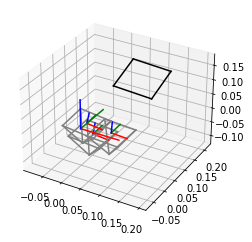

In [9]:
scene.calibrate_extrinsics(
    detected_markers_ls=marker_observations,
    frame_transforms_ls=[[("world", "ee", ee_pose)] for ee_pose in ee_poses],
    verbosity=1,
)

scene.visualize()